In [1]:
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
import sys
import random
import pyautogui
from PyQt5 import QtWidgets, uic
import time
import csv #엑셀파일
import os
import win32com.client 
from openpyxl import Workbook
import xlwt
import math
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import openpyxl 
import matplotlib.pyplot as plt
import keras
import icon_rc
import webbrowser

# LSTM for international airline passengers problem with memory
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
basic_ui = uic.loadUiType("UI_design.ui")[0]

In [3]:
#버튼 출력 윈도우창   
class WindowClass(QMainWindow, basic_ui):
    def __init__(self):
        super().__init__()
        self.setupUi(self)

        self.cnt = 0
        
        self.x_data=[]
        self.y_data=[]
        self.speed=[]
        self.n = 0

        self.kwangwoon_btn.clicked.connect(self.ClickMethod)
        self.naver_btn.clicked.connect(self.ClickMethod)
        self.google_btn.clicked.connect(self.ClickMethod)
        self.youtube_btn.clicked.connect(self.ClickMethod)
        #self.excel_btn.clicked.connect(self.createCsv)

        self.show()
        
        qr = self.frameGeometry()
        cp = QDesktopWidget().availableGeometry().center()
        qr.moveCenter(cp)
        self.move(qr.topLeft())
    
    def ClickMethod(self):        

            # 안쪽 리스트로 사용할 빈 리스트 생성
            line_x = []
            line_y = []
            line_speed=[]

            for j in range(100):
                x,y=pyautogui.position()
                line_x.append(x)
                line_y.append(y)# 안쪽 리스트에 0 추가
                time.sleep(0.001)

            self.x_data.append(line_x)
            self.y_data.append(line_y)
            
            for i in range(1, len(line_x)):
                Speed=((line_x[i]-line_x[i-1])**2) + ((line_y[i]-line_y[i-1])**2)
                Speed=math.sqrt(Speed)
                line_speed.append(Speed)
            self.speed.append(line_speed)
            
    def mouseMoveEvent(self, e):
            txt="마우스 위치 x={0}, y={1}".format(e.x(),e.y())
            self.statusbar.showMessage(txt)   
            
            #lstm 결과좌표 넣기
            x_position=int(format(e.x()))  #test용
            y_position=int(format(e.y()))  #test용
            
            n=0  #결과에따라 사이트 이동
            while(n==0):
                if 0<x_position and x_position<175 :
                    if 0<y_position and y_position<160:
                        #kwu
                        url = 'https://www.kw.ac.kr/ko/'
                        webbrowser.open(url)
                    if 160<y_position and y_position<320:
                        #naver
                        url = 'https://www.naver.com/'
                        webbrowser.open(url)
                if 175<x_position and x_position<350:
                    if 0<y_position and y_position<160:
                        #google
                        url = 'https://www.google.co.kr/'
                        webbrowser.open(url)
                    if 160<y_position and y_position<320:
                        #youtube
                        url = 'https://www.youtube.com/'
                        webbrowser.open(url)
                n+=1;
                
                #openUrl(x_position, y_position)                

app = QApplication([])
ex = WindowClass()
sys.exit(app.exec_())

SystemExit: 0

C:\anaconda\envs\LKMouse\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [],[] 
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back):]
        dataX.append(a)
        dataY.append(dataset[i:(i + look_back):])
    
    dataX=np.squeeze(dataX,axis=1) #차원 축소
    dataY=np.squeeze(dataY,axis=1) #차원 축소
    return np.array(dataX), np.array(dataY)

In [5]:
# np.random.seed(7) #결과를 재현할 수 있도록 난수 시드 수정
data1=pd.read_excel('total_x.xlsx') #x좌표 엑셀 데이터 불러옴 
data2=pd.read_excel('total_y.xlsx') #x좌표 엑셀 데이터 불러옴 
data3=pd.read_excel('total_speed.xlsx') #x좌표 엑셀 데이터 불러옴 

pddata1=pd.DataFrame(data1) 
pddata1.head()
pddata2=pd.DataFrame(data2) 
pddata2.head()
pddata3=pd.DataFrame(data3) 
pddata3.head()

hap=[] #진짜 합
for j in range(len(pddata1)):
    x_data=np.array(pddata1.loc[j])
    y_data=np.array(pddata2.loc[j])
    s_data=np.array(pddata3.loc[j])

    hap1=[] #[x,y,속력] 데이터를 저장하고 있는 리스트

    for i in range(len(s_data)): 
        sum=[] #리스트 하나당 임시로 x,y,속력을 저장할 리스트 (for문 돌릴때마다 초기화)
        sum.append(x_data[i]) #x넣음
        sum.append(y_data[i]) #y넣음
        sum.append(s_data[i]) #속력넣음
        hap1.append(sum) #[x,y,속력] 하나의 리스트를 hap리스트에 넣음  

    j = j + 1
    
    hap.append(hap1)

n1 = np.array(hap)
print(n1.shape) #6532,99,3 6532개의 샘플과 100개 시계열, 3개 피쳐(x,y,속력)

(6532, 99, 3)


In [6]:
num_sample = n1.shape[0] # 257개 샘플 데이터
num_sequence = n1.shape[1] # 99개 시계열 데이터
num_feature = n1.shape[2] #3개 피쳐

dataset = n1

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler() #클래스의 인스턴스 생성

#시계열 선회하면서 피팅함
#for ss in range(num_sequence):
#    scaler.partial_fit(n1[:,ss,:])
    
#Numpy 활용하여 3차원 데이터 스케일링(변환) 0~1 스케일링
#results=[]
#for ss in range(num_sequence):
#    results.append(scaler.transform(n1[:,ss,:]).reshape(num_sample,1,num_feature))
#n1_scaled = np.concatenate(results, axis=1)

#dataset=  n1_scaled

In [7]:
train_size = int(len(dataset) * 0.7) #학습 데이터 67%
test_size = len(dataset) - train_size #테스트 데이터 33%
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 1

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
#LSTM 모델 생성

from keras.layers import TimeDistributed
from keras.layers import InputLayer
from keras.layers import Reshape

model = Sequential() # Sequeatial Model 

model.add(LSTM(64,return_sequences=True, input_shape=(num_sequence,num_feature)))  
model.add(Dense(3, activation='softmax')) # 3개의 예측
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
history=model.fit(trainX, trainY, epochs=300, batch_size=10, validation_split=0.2, verbose=1,callbacks=[early_stopping])

model.summary()

Train on 3656 samples, validate on 914 samples
Epoch 1/300
3656/3656 [==============================] - 35s 10ms/step - loss: 905.7772 - accuracy: 0.9962 - val_loss: 850.4271 - val_accuracy: 1.0000
Epoch 2/300
3656/3656 [==============================] - 33s 9ms/step - loss: 872.6472 - accuracy: 0.9999 - val_loss: 848.2939 - val_accuracy: 1.0000
Epoch 3/300
3656/3656 [==============================] - 34s 9ms/step - loss: 870.9056 - accuracy: 1.0000 - val_loss: 847.4486 - val_accuracy: 1.0000
Epoch 4/300
3656/3656 [==============================] - 34s 9ms/step - loss: 870.4000 - accuracy: 1.0000 - val_loss: 847.2951 - val_accuracy: 1.0000
Epoch 5/300
3656/3656 [==============================] - 34s 9ms/step - loss: 870.2819 - accuracy: 1.0000 - val_loss: 847.2637 - val_accuracy: 1.0000
Epoch 6/300
3656/3656 [==============================] - 34s 9ms/step - loss: 870.2350 - accuracy: 1.0000 - val_loss: 847.2458 - val_accuracy: 1.0000
Epoch 7/300
3656/3656 [=============================

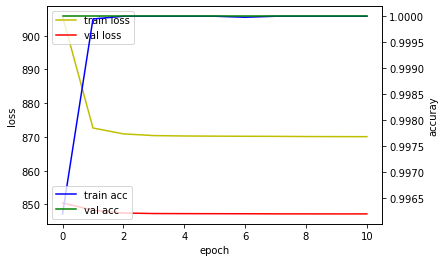

4570/4570 [==============================] - 5s 999us/step
accuracy: 100.00%


In [9]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

scores = model.evaluate(trainX, trainY)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

In [10]:
predict_e = model.predict(format(e.x(),e.y()))
ex.mouseMoveEvent(predict_e)

NameError: name 'e' is not defined